In [15]:
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [36]:
%pip install jax jaxlib

  Using cached jax-0.4.6.tar.gz (1.2 MB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 MB 2.8 MB/s eta 0:00:0000:0100:01
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached scipy-1.10.1-cp311-cp311-macosx_10_9_x86_64.whl (35.0 MB)
  Created wheel for jax: filename=jax-0.4.6-py3-none-any.whl size=1432714 sha256=9c4506d48c24717eb04e8f1b54064510e28d5ee3888f2ce6a6218063b510c006
  Stored in directory: /Users/g0bel1n/Library/Caches/pip/wheels/6a/28/40/ff10677acfec585e1716fbe856cf037a1f219f132df3b39b5a
Successfully built jax
Note: you may need to restart the kernel to use updated packages.


In [2]:
with open('../data/training_data.pkl', 'rb') as f:
    train_data = pickle.load(f)

with open('../data/test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

with open('../data/training_labels.pkl', 'rb') as f:
    train_labels = pickle.load(f)
    

In [3]:
G1, G2 = train_data[0], train_data[1]

In [4]:
class Walk:

    def __init__(self, path):
        self.path = path

    def __eq__(self, other):
        #recursively check if two walks are equal
        if len(self.path) != len(other.path):
            return False
        elif len(self.path) == 1:
            return self.path[0] == other.path[0]
        else:
            return self.path[0] == other.path[0] and self.path[1:] == other.path[1:]
        
    def __hash__(self):
        return hash(tuple(self.path))
    
def product_graph(G1, G2, edge_agg = np.sum):
        G = nx.Graph()
        for n1 in G1.nodes:
            for n2 in G2.nodes:
                if G1.nodes[n1]['labels'] == G2.nodes[n2]['labels']:
                    G.add_node((n1, n2), labels=G1.nodes[n1]['labels'])
        for e1 in G1.edges:
            for e2 in G2.edges:
                if (e1[0], e2[0]) in G.nodes and (e1[1], e2[1]) in G.nodes:
                    G.add_edge((e1[0], e2[0]), (e1[1], e2[1]), labels=[edge_agg((G1.edges[e1]['labels'],G1.edges[e1]['labels']))])
        return G




In [ ]:
from abc import ABC, abstractmethod


class GraphKernel(ABC):

    def __init__(self):
        pass


    def __call__(self, x1, x2):
        if isinstance(x1, nx.Graph) and isinstance(x2, nx.Graph):
            return self.kernel(x1, x2)
        elif isinstance(x1, list) and isinstance(x2, list):
            return np.array([[self.kernel(x1[i], x2[j]) for i in range(len(x1))] for j in range(len(x2))])


    @abstractmethod
    def kernel(self, G1, G2):
        pass

    def _graph_product_connex_components(self, G1 : nx.Graph, G2 : nx.Graph, edge_agg = np.sum) -> nx.Graph:
        Gx = product_graph(G1, G2, edge_agg = edge_agg)
        if not (
            connected_sub_graphs := [
                Gx.subgraph(c) for c in nx.connected_components(Gx)
            ]
        ):
            return np.nan
        #keep largest connected component
        Gx = max(connected_sub_graphs, key=len)
        return Gx




class RandomWalkKernelBase(GraphKernel, ABC):
    def __init__(self, len_max: int, n_walks: int):
        self.len_max = len_max
        self.n_walks = n_walks

        
    @staticmethod
    def _random_walk(G : nx.Graph, len_max: int):
        """
        Random walk on graph G, starting from node 0, with maximum length len_max
        """
        idx= np.random.choice(np.arange(len(G.nodes)))
        path = [list(G.nodes)[idx]]
        for _ in range(len_max):
            if neighbors := list(G.neighbors(path[-1])):
                idx = np.random.choice(np.arange(len(neighbors)))
                path.append(neighbors[idx])
            else:
                break
        return Walk(path)
    
    def _get_walks(self, G : nx.Graph):
        """
        Get a list of random walks on graph G
        """
        return [self._random_walk(G, self.len_max) for _ in range(self.n_walks)]
    


In [25]:
class RandomWalkKernel(RandomWalkKernelBase):

    def __init__(self, len_max: int, n_walks: int):
        super().__init__(len_max, n_walks)



    def _geometric_random_walk_kernel(self,G1 : nx.Graph, G2 : nx.Graph):
        """
        Random walk kernel between graphs G1 and G2
        """

        Gx = self._graph_product_connex_components(G1, G2)
        if np.isnan(Gx):
            return np.nan
        
        walks = self._get_walks(Gx)

        transitions_matrix = np.zeros((len(Gx.nodes), len(Gx.nodes)))

        n_nodes_visited = 0
        for walk in walks:
            for i in range(len(walk.path)-1):
                transitions_matrix[walk.path[i]][walk.path[i+1]] += (Gx[walk.path[i]][walk.path[i+1]]['labels'][0]+1)**(Gx.nodes[walk.path[i]]['labels'][0]+1)
                transitions_matrix[walk.path[i+1]][walk.path[i]] += (Gx[walk.path[i]][walk.path[i+1]]['labels'][0]+1)**(Gx.nodes[walk.path[i+1]]['labels'][0]+1)
            n_nodes_visited += len(walk.path)

        #normalize transitions matrix to get a probability matrix, beware of 0s

        transitions_matrix = transitions_matrix / n_nodes_visited

        #normalize transitions matrix to get a probability matrix, beware of 0s
        np.fill_diagonal(transitions_matrix, 0)
        #cols= transitions_matrix.sum(axis=1)!=0
        #transitions_matrix[cols] /= transitions_matrix[cols].sum(axis=1)[:,None]
        initial_distribution = np.ones(len(Gx.nodes))/len(Gx.nodes)

        #print(transitions_matrix)
        #print(np.max(np.linalg.inv(np.eye(len(Gx.nodes))-transitions_matrix)))
        return initial_distribution @ np.linalg.inv(np.eye(len(Gx.nodes))-transitions_matrix) @ np.ones(len(Gx.nodes))
        #return transitions_matrix
    def copy(self):
        return RandomWalkKernel(self.len_max, self.n_walks)


class nthOrderKernel(GraphKernel):
    def __init__(self, n: int = 5):
        self.n = n

    def kernel(self, G1, G2):
        A = self._graph_product_connex_components(G1, G2).adjacency_matrix().todense()
        one_vec = np.ones(A.shape[0])
        return one_vec @ np.linalg.matrix_power(A, self.n) @ one_vec
    

class GeometricRandomWalkKernel(RandomWalkKernelBase):

    def __init__(self, len_max: int, n_walks: int, beta : float = 1.1):
        super().__init__(len_max, n_walks)

    def kernel(self, G1, G2):
        
        Gx = self._graph_product_connex_components(G1, G2)
        if np.isnan(Gx):
            return np.nan
        
        walks = self._get_walks(Gx)

        #WIP







            
        
    

    

In [26]:
rwk = RandomWalkKernel()


In [452]:
Gx = rwk.product_graph(G1, G2)

In [453]:
mapping = {node: i for i, node in enumerate(Gx.nodes)}
Gx = nx.relabel_nodes(Gx, mapping)

In [7]:
from multiprocessing import Pool
from functools import partial

In [20]:
from tqdm import tqdm

In [27]:
class knn:
        
        def __init__(self, k=5, kernel=RandomWalkKernel()) -> None:
            self.k = k
            self.kernel = kernel
            
        def fit(self, X, y):
            self.X = X
            self.y = y

            return self
        
        @staticmethod
        def compute_score(kernel, ref, base):
            return [kernel(ref, b) for b in base]
        
        def predict(self, X):
            y_pred = []
            for x in tqdm(X):
                scores = np.array(self.compute_score(self.kernel, x, self.X))
                idx = np.argsort(scores)[-self.k:]
                y_pred.append(self.y[idx].mean())
            return np.array(y_pred)
        
        def score(self, X, y):
            return np.mean(self.predict(X)==y)

In [28]:
knn = knn(k=5, kernel=RandomWalkKernel()).fit(train_data[:200], train_labels[:200]).score(train_data[300:400], train_labels[300:400])

100%|██████████| 100/100 [14:28<00:00,  8.68s/it]


In [29]:
knn

0.41

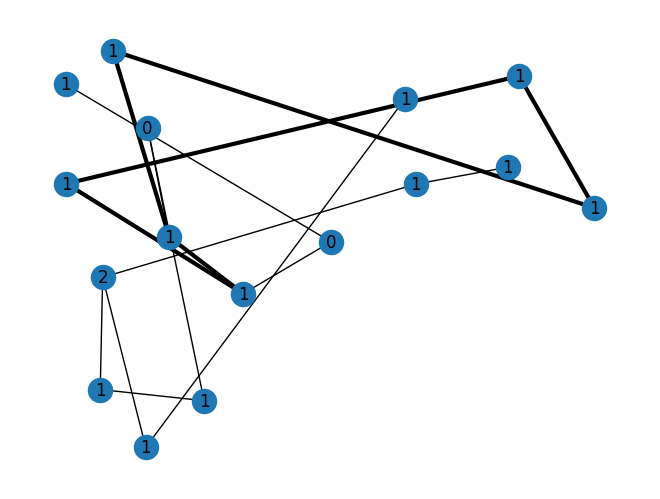

In [19]:
pos1 = nx.spring_layout(G1)
draw_molecule(G1, pos=pos)


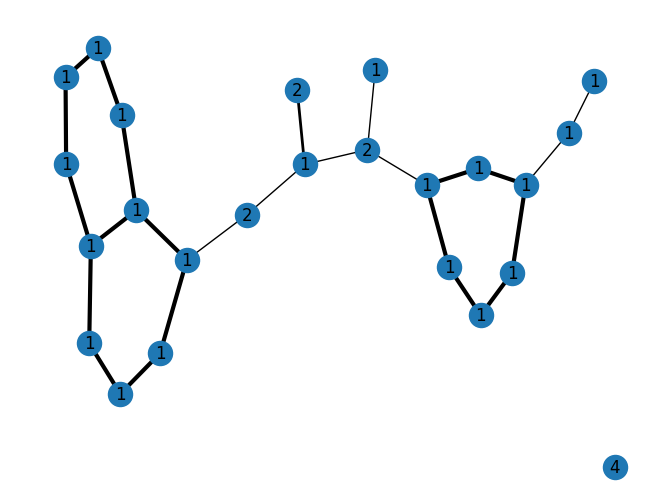

In [20]:
pos2 = nx.spring_layout(G2)
draw_molecule(G2, pos=pos)

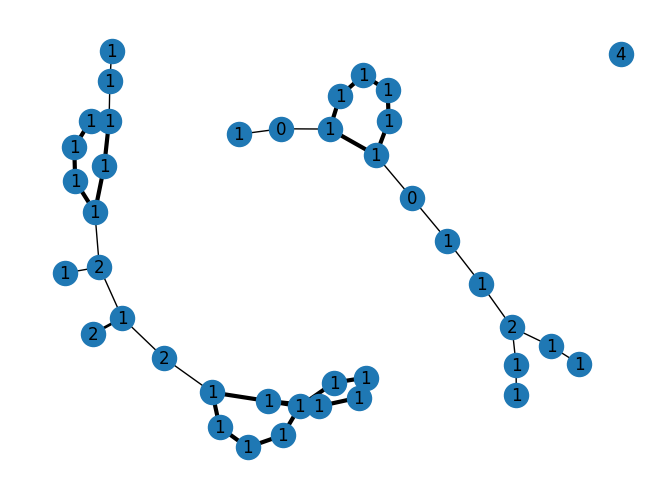

In [24]:
# product graph 

In [122]:
def draw_molecule(G, **kwargs):
    pos = nx.spring_layout(G) if 'pos' not in kwargs else kwargs.pop('pos')
    
    nx.draw(G,pos=pos, width = [G.edges[e]['labels'][0]+1 for e in G.edges], **kwargs)
    kwargs = {k:v for k,v in kwargs.items() if k in nx.draw_networkx_labels.__code__.co_varnames}
    nx.draw_networkx_labels(G, pos=pos, labels={n:G.nodes[n]['labels'][0] for n in G.nodes}, **kwargs)

In [308]:
def product_graph(G1, G2):
    G = nx.Graph()
    for n1 in G1.nodes:
        for n2 in G2.nodes:
            if G1.nodes[n1]['labels'] == G2.nodes[n2]['labels']:
                G.add_node((n1, n2), labels=G1.nodes[n1]['labels'])
    for e1 in G1.edges:
        for e2 in G2.edges:
            if (e1[0], e2[0]) in G.nodes and (e1[1], e2[1]) in G.nodes:
                G.add_edge((e1[0], e2[0]), (e1[1], e2[1]), labels=[np.max((G1.edges[e1]['labels'],G1.edges[e1]['labels']))])
    return G

In [129]:
G_pord = product_graph(G1, G2)

In [130]:
print(G1.nodes(data=True))

[(0, {'labels': [1]}), (1, {'labels': [1]}), (2, {'labels': [2]}), (3, {'labels': [0]}), (4, {'labels': [0]}), (5, {'labels': [1]}), (6, {'labels': [1]}), (7, {'labels': [1]}), (8, {'labels': [1]}), (9, {'labels': [1]}), (10, {'labels': [1]}), (11, {'labels': [1]}), (12, {'labels': [1]}), (13, {'labels': [1]}), (14, {'labels': [1]}), (15, {'labels': [1]})]


In [131]:
print(G_pord.nodes(data=True))

[((0, 0), {'labels': [1]}), ((0, 1), {'labels': [1]}), ((0, 2), {'labels': [1]}), ((0, 3), {'labels': [1]}), ((0, 5), {'labels': [1]}), ((0, 6), {'labels': [1]}), ((0, 7), {'labels': [1]}), ((0, 8), {'labels': [1]}), ((0, 9), {'labels': [1]}), ((0, 10), {'labels': [1]}), ((0, 11), {'labels': [1]}), ((0, 14), {'labels': [1]}), ((0, 15), {'labels': [1]}), ((0, 16), {'labels': [1]}), ((0, 17), {'labels': [1]}), ((0, 18), {'labels': [1]}), ((0, 19), {'labels': [1]}), ((0, 20), {'labels': [1]}), ((0, 21), {'labels': [1]}), ((0, 22), {'labels': [1]}), ((1, 0), {'labels': [1]}), ((1, 1), {'labels': [1]}), ((1, 2), {'labels': [1]}), ((1, 3), {'labels': [1]}), ((1, 5), {'labels': [1]}), ((1, 6), {'labels': [1]}), ((1, 7), {'labels': [1]}), ((1, 8), {'labels': [1]}), ((1, 9), {'labels': [1]}), ((1, 10), {'labels': [1]}), ((1, 11), {'labels': [1]}), ((1, 14), {'labels': [1]}), ((1, 15), {'labels': [1]}), ((1, 16), {'labels': [1]}), ((1, 17), {'labels': [1]}), ((1, 18), {'labels': [1]}), ((1, 19),

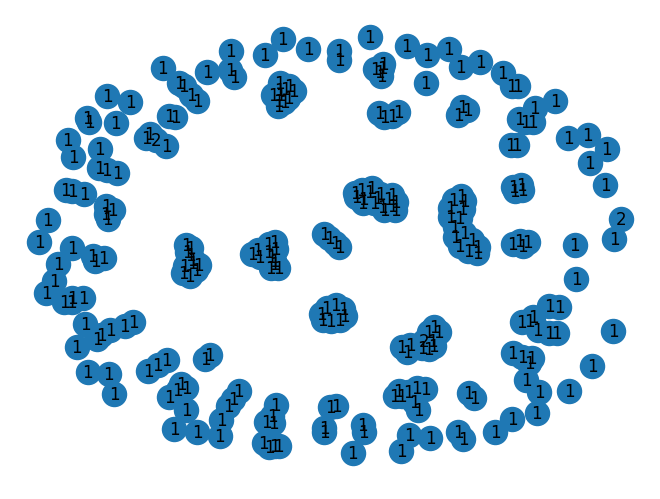

In [132]:
draw_molecule(G_pord)

In [137]:
G1.number_of_edges() * G2.number_of_edges()

400

In [138]:
G_pord.number_of_edges()

180

In [120]:
G_pord.nodes

NodeView(((0, 0), (0, 1), (0, 2), (0, 3), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (1, 0), (1, 1), (1, 2), (1, 3), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (2, 4), (2, 12), (2, 13), (5, 0), (5, 1), (5, 2), (5, 3), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 14), (5, 15), (5, 16), (5, 17), (5, 18), (5, 19), (5, 20), (5, 21), (5, 22), (6, 0), (6, 1), (6, 2), (6, 3), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 14), (6, 15), (6, 16), (6, 17), (6, 18), (6, 19), (6, 20), (6, 21), (6, 22), (7, 0), (7, 1), (7, 2), (7, 3), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (7, 10), (7, 11), (7, 14), (7, 15), (7, 16), (7, 17), (7, 18), (7, 19), (7, 20), (7, 21), (7, 22), (8, 0), (8, 1), (8, 2), (8, 3), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (8, 10), (8, 11), (8, 14), (8, 15), (

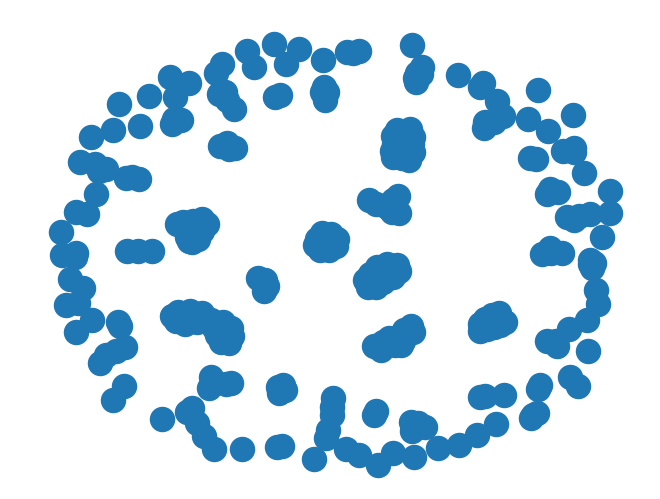

In [121]:
nx.draw(G_pord, width = [G_pord.edges[e]['labels'][0]+1 for e in G_pord.edges])

In [115]:
[G_pord.edges[e]['labels'][0]+1 for e in G_pord.edges]

[5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5]

In [164]:
def _random_walk(G : nx.Graph, len_max: int):
        """
        Random walk on graph G, starting from node 0, with maximum length len_max
        """
        idx= np.random.choice(np.arange(len(G.nodes)))
        path = [list(G.nodes)[idx]]
        for _ in range(len_max):
            if neighbors := list(G.neighbors(path[-1])):
                idx = np.random.choice(np.arange(len(neighbors)))
                path.append(neighbors[idx])
            else:
                break
        return Walk(path)

In [8]:
class Walk:

    def __init__(self, path):
        self.path = path

    def __eq__(self, other):
        #recursively check if two walks are equal
        if len(self.path) != len(other.path):
            return False
        elif len(self.path) == 1:
            return self.path[0] == other.path[0]
        else:
            return self.path[0] == other.path[0] and self.path[1:] == other.path[1:]
        
    def __hash__(self):
        return hash(tuple(self.path))
    


In [1]:
%pip install grakel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 3.4 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.33-py2.py3-none-any.whl (987 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 11.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 9.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  error: subprocess-exited-with-error
  
  × Building wheel for grakel (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [244 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.macosx-10.9-x86_64-cpython-311
      creating build/lib.macosx-10